In [260]:
from lightjob.cli import load_db
from lightjob.db import SUCCESS, RUNNING
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from pyearth import Earth
from sklearn.gaussian_process import GaussianProcess
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score, KFold, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.gaussian_process import GaussianProcess
from sklearn.base import clone
from sklearn.cross_validation import train_test_split
import json
import collections
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
%matplotlib inline

class EarthOneVsRestClassifier(BaseEstimator):

    def __init__(self, **params):
        pipeline = Pipeline([
                ('earth', (Earth(**params))),
                ('logistic', LogisticRegression())
            ])
        self.clf = OneVsRestClassifier(pipeline)

    def fit(self, X, y):
        return self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

class EnsembleRegressor(object):
    def __init__(self, regs=None):
        self.regs = regs

    def fit(self, X, y):
        return self

    def predict(self, X, return_std=False):
        if return_std:
            means = []
            stds = []
            for r in self.regs:
                m, s = r.predict(X, return_std=True)
                means.append(m)
                stds.append(s)
            means = np.vstack(means).T
            stds = np.vstack(stds).T
            return np.mean(means, axis=1), (np.sqrt((stds**2).sum(axis=1)) / stds.shape[1])
        else:
            preds = np.vstack([r.predict(X) for r in self.regs]).T
            return np.mean(preds, axis=1)


def plot_imp(names, values):
    ind = (np.arange(len(names)))
    plt.xticks(ind + 0.5, names)
    plt.bar(ind, values, width=1)
    plt.xlabel('variable index')
    plt.ylabel('importance')

    
def mse(model, X, y):
    m = model
    return ((m.predict(X) - y)**2).mean() 

def acc(model, X, y):
    return (model.predict(X) == y).mean()

def evaluate(model, X, y, score=mse):
    train_scores = []
    test_scores = []
    models = []
    for train, test in KFold(X.shape[0], n_folds=2, shuffle=True, random_state=4):
        m = clone(model)
        m.fit(X[train], y[train])
        train_scores.append(score(m, X[train], y[train]) )
        test_scores.append(score(m, X[test], y[test]) )
        models.append(m)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    return models, train_scores, test_scores

from sklearn.svm import SVR

def smooth_image(x, y, z, w=100, h=100, model=SVR()):
    X = np.vstack((x, y)).T
    model.fit(X, z)
    x, y = np.meshgrid(
        np.linspace(x.min(), x.max(), w),
        np.linspace(y.min(), y.max(), h)
    )
    x = x.flatten()
    y = y.flatten()
    xs = np.vstack((x, y)).T
    zs = model.predict(xs)
    zs = zs.reshape((w, h))
    return zs

def flatten_dict(l):
    d = {}
    for k, v in l.items():
        if isinstance(v, collections.Mapping):
            d.update(flatten_dict(v))
        elif isinstance(v, list) or isinstance(v, tuple):
            for i, l in enumerate(v):
                d[k+'_{}'.format(i)] = l
        else:
            d[k] = v
    return d

In [2]:
db = load_db()

In [3]:
jobs = db.jobs_with(state=SUCCESS)
jobs = list(jobs)

In [21]:
stats = defaultdict(list)
for j in jobs:

    for k, v in j['content']['model'].items():
        stats[k].append(v)
    
    if j['hist'] is not None:  
        for h in j['hist'][0].keys():
            d = [a[h] for a in j['hist']]
            stats[h].append(d)
    stats['summary'].append(j['summary'])
    stats['where'].append(j['where'])
df = pd.DataFrame(stats)

df['last_g_loss'] = df['g_loss'].apply(lambda l:l[-1])
df['last_d_loss'] = df['d_loss'].apply(lambda l:l[-1])
df['min_g_loss'] = df['g_loss'].apply(lambda l:np.min(l))
df['min_d_loss'] = df.apply(lambda c:c['d_loss'][np.argmin(c['g_loss'])], axis=1)
df['ratio_loss'] = df['last_g_loss'] / df['last_d_loss']

In [22]:
pd.set_option('display.max_columns', None)
df = df.sort_values(by='ratio_loss', ascending=True)

In [55]:
from IPython.display import Image, display
summaries = df['summary']
for s in summaries:
    filename = 'results/{}/samples00200.png'.format(s)
    #print(filename)
    #display(Image(filename))

In [68]:
df_x = df[['num_filters_d', 'num_filters_g', 'scale', 'do_batch_norm', 'start_w', 'start_h', 'filter_size', 'where']]
df_x = pd.get_dummies(df_x)
colnames = df_x.columns
df_x.head()

,num_filters_d,num_filters_g,scale,do_batch_norm,start_w,start_h,filter_size,where_js1,where_js2,where_js3,where_js4,where_js5,where_js6
169,16,32,0.000562,True,4,4,5,0.0,1.0,0.0,0.0,0.0,0.0
43,16,64,0.000562,True,4,4,5,1.0,0.0,0.0,0.0,0.0,0.0
79,16,128,0.003162,True,4,4,5,1.0,0.0,0.0,0.0,0.0,0.0
42,16,64,0.000562,True,4,4,5,1.0,0.0,0.0,0.0,0.0,0.0
3,8,32,0.000100,True,4,4,5,1.0,0.0,0.0,0.0,0.0,0.0


In [202]:
X = df_x.values
y = df[['last_d_loss']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [203]:
models = {
   'Earth': Earth(max_degree=2, max_terms=10, 
                  smooth=False, thresh=0, minspan=1, 
                  check_every=1,
                  verbose=0,
                  feature_importance_type='rss',
                  endspan=1),
    'RandomForestRegressor': RandomForestRegressor(max_depth=20, n_estimators=10),
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'DummyRegressor': DummyRegressor(),
}
result = {}
cols = defaultdict(list)
for name, m in models.items():
    models, train, valid = evaluate(m, X_train, y_train)
    cols['model'].append(m.__class__.__name__)
    cols['train_mean'].append(train.mean())
    cols['train_std'].append(train.std())
    cols['valid_mean'].append(valid.mean())
    cols['valid_std'].append(valid.std())
    #cols['test'].append
    result[name] = models
#earth = models[0]
#earth.fit(X, y)
results = pd.DataFrame(cols)
results = results.sort_values(by='valid_mean')
results

/home/ubuntu/miniconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,model,train_mean,train_std,valid_mean,valid_std
2,LinearRegression,0.090766,0.009073,0.102177,0.011565
3,DummyRegressor,0.281898,0.008911,0.282085,0.008911
1,Lasso,0.445353,0.034764,0.448991,0.009313
0,Earth,0.485852,0.028871,0.485842,0.017331
4,RandomForestRegressor,0.516084,0.016666,0.520745,0.025328


In [204]:
last_model = result[results.iloc[0]['model']][0]
mse(last_model, X_test, y_test)

0.095355878416245779

## Linear regression

In [176]:
lin = result['LinearRegression'][0]

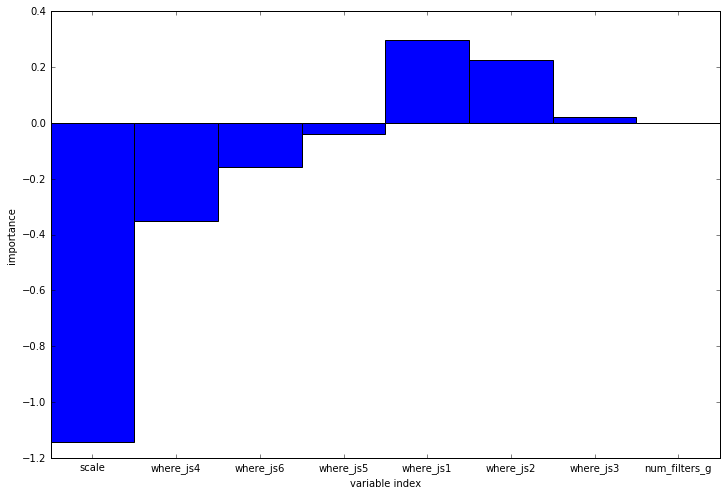

In [177]:
for imp in lin.coef_:
    indices = range(len(imp))
    low = sorted(indices, key=lambda i:imp[i])
    low = low[0:4]
    high = sorted(indices, key=lambda i:-imp[i])
    high = high[0:4]
    indices = low + high
    names = colnames
    names = map(lambda i:names[i], indices)
    imp = map(lambda i:imp[i], indices)
    fig = plt.figure(figsize=(12, 8))
    plot_imp(names, imp)
    plt.show()

## Earth

In [101]:
earth = result['earth'][0]
print(earth.summary())

Earth Model
--------------------------------------
Basis Function  Pruned  Coefficient   
--------------------------------------
(Intercept)     No      0.362423      
x0              No      0.146794      
x10             No      1.42811       
x0*x0           No      -0.000835107  
x8*x0           No      -0.0747142    
x7*x0           No      -0.0537206    
--------------------------------------
MSE: 1.4588, GCV: 1.6639, RSQ: 0.7252, GRSQ: 0.6895


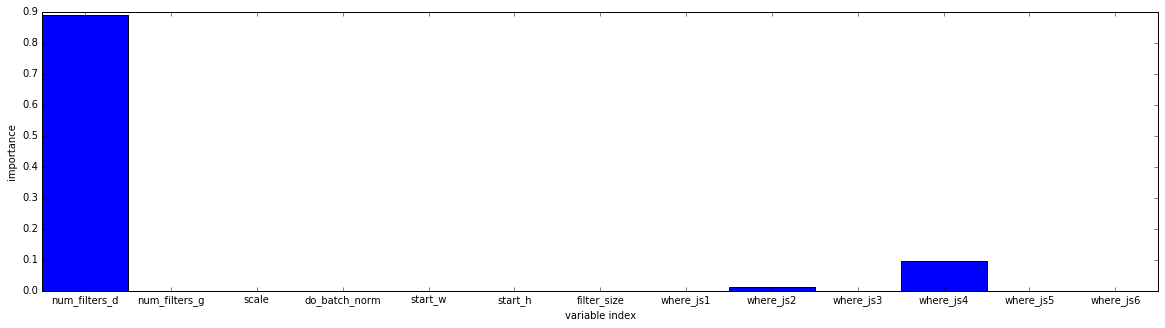

In [102]:
fig = plt.figure(figsize=(20, 5))
plot_imp(colnames, earth.feature_importances_)

## By using images

In [298]:
df = pd.read_csv('http://127.0.0.1:20000/export_data?type=classification&class=gan')

In [299]:
df.head()

,id,hypers,user,label
0,6b4b62c1c2f5eecbfb032fb6e9ef8b4c,"{""c"": 1, ""h"": 32, ""subset_ratio"": 1, ""dataset""...",mehdi,bad
1,46d26dd46f950a388388f63e50f53259,"{""c"": 1, ""h"": 32, ""subset_ratio"": 1, ""dataset""...",mehdi,okay
2,d345decc2ff601f5c2c7a078460e4b4b,"{""c"": 1, ""h"": 32, ""subset_ratio"": 0.01, ""datas...",mehdi,very_bad
3,f250d94c5239ed8cc87fd190f9e57642,"{""c"": 1, ""h"": 32, ""subset_ratio"": 1, ""dataset""...",mehdi,bad
4,73790554afe39027ca68cdb3bacecd97,"{""c"": 1, ""h"": 32, ""subset_ratio"": 1, ""dataset""...",mehdi,okay


In [300]:
colnames = set()
for i in range(len(df)):
    h = df['hypers'].iloc[i]
    h = json.loads(h)
    h = flatten_dict(h)
    colnames |= set(h.keys())
colnames = list(colnames)
print(colnames)
for col in colnames:
    df[col] = df.apply(lambda r:flatten_dict(json.loads(r['hypers'])).get(col), axis=1)
#df['nb_filters']

[u'subset_ratio', u'do_batch_norm', u'dataset', u'filter_size', u'seed', u'b1', u'nb_epochs', u'epoch_start_decay', u'c', u'scale', u'start_h', u'num_filters_d', u'h', u'num_filters_g', u'lr_decay', u'lr', u'l2_coef', u'w', u'start_w', u'model_name']


In [317]:
cols = colnames
x_df = df[cols]
y_df = df['label'].copy()

"""
y_df[y_df == 'excellent'] = '+'
y_df[y_df == 'good'] = '+'
y_df[y_df == 'okay'] = '+'
y_df[y_df == 'bad'] = '-'
y_df[y_df == 'very_bad'] = '-'
"""

x_df = pd.get_dummies(x_df, columns=cols)
x_df.head()

,subset_ratio_0.01,subset_ratio_0.1,subset_ratio_1.0,do_batch_norm_True,dataset_fonts,dataset_insects,dataset_mnist,filter_size_5,seed_42.0,b1_0.5,nb_epochs_100,nb_epochs_200,epoch_start_decay_100.0,c_1,c_3,scale_0.0001,scale_0.00056234132519,scale_0.00316227766017,scale_0.0177827941004,scale_0.1,start_h_4,num_filters_d_4,num_filters_d_8,num_filters_d_16,num_filters_d_32,num_filters_d_64,num_filters_d_128,h_32,h_64,num_filters_g_32,num_filters_g_64,num_filters_g_128,num_filters_g_256,num_filters_g_512,num_filters_g_1024,lr_decay_0.9,lr_decay_0.97,lr_decay_0.99,lr_decay_1.0,lr_1e-05,lr_5e-05,lr_0.0002,lr_0.001,l2_coef_0.0,l2_coef_1e-07,l2_coef_1e-05,l2_coef_0.001,w_32,w_64,start_w_4,model_name_dcgan
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [318]:
X = x_df.values
y = y_df.values

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [320]:
models = {
   'EarthOneVsRestClassifier': EarthOneVsRestClassifier(max_degree=2, max_terms=10, 
                  smooth=False, thresh=0, minspan=1, 
                  check_every=1,
                  verbose=0,
                  feature_importance_type='rss',
                  endspan=1),
    'RandomForestClassifier': RandomForestClassifier(max_depth=20, n_estimators=10),
    'LogisticRegression': LogisticRegression(),
    'DummyClassifier': DummyClassifier(),
}
result = {}
cols = defaultdict(list)
for name, m in models.items():
    models, train, valid = evaluate(m, X_train, y_train, score=acc)
    cols['model'].append(m.__class__.__name__)
    cols['train_mean'].append(train.mean())
    cols['train_std'].append(train.std())
    cols['valid_mean'].append(valid.mean())
    cols['valid_std'].append(valid.std())
    #cols['test'].append
    result[name] = models
#earth = models[0]
#earth.fit(X, y)
results = pd.DataFrame(cols)
results = results.sort_values(by='valid_mean', ascending=False)
results

,model,train_mean,train_std,valid_mean,valid_std
2,EarthOneVsRestClassifier,0.707547,0.047170,0.622642,0.000000
1,LogisticRegression,0.779874,0.006289,0.603774,0.012579
3,RandomForestClassifier,0.990566,0.003145,0.566038,0.006289
0,DummyClassifier,0.355346,0.022013,0.377358,0.018868


In [323]:
print(classification_report(best_model.predict(X_test), y_test))

             precision    recall  f1-score   support

        bad       0.73      0.46      0.56        35
       good       0.25      0.14      0.18         7
       okay       0.14      0.40      0.21         5
   very_bad       0.77      0.86      0.82        59

avg / total       0.69      0.66      0.66       106



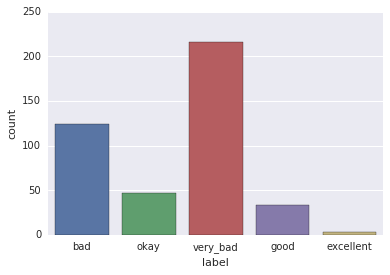

In [324]:
sns.countplot(y_df)

In [322]:
best_model = result[results.iloc[0]['model']][0]
acc(best_model, X_test, y_test)

0.660377358490566

In [264]:
print(classification_report(best_model.predict(X_test), y_test))

             precision    recall  f1-score   support

        bad       0.66      0.56      0.60        34
       good       0.30      0.60      0.40         5
       okay       0.10      0.08      0.09        13
   very_bad       0.79      0.83      0.81        54

avg / total       0.64      0.64      0.64       106

